In [18]:
import pandas as pd
from statsforecast import StatsForecast
from statsforecast.models import Naive
import matplotlib.pyplot as plt
import statsforecast as sf
from sktime.utils.plotting import plot_series
import numpy as np
from sktime.forecasting.ets import AutoETS
from sktime.forecasting.base import ForecastingHorizon
from sklearn.metrics import mean_absolute_percentage_error
from sktime.forecasting.arima import AutoARIMA
from sktime.forecasting.fbprophet import Prophet
from sktime.forecasting.model_selection import ForecastingGridSearchCV, ExpandingWindowSplitter
from sktime.performance_metrics.forecasting import MeanAbsolutePercentageError

import warnings
warnings.filterwarnings("ignore")

import logging
logging.getLogger("cmdstanpy").setLevel(logging.WARNING)
logging.disable(logging.CRITICAL)

df = pd.read_excel('Downloads/CMO-Historical-Data-Monthly.xlsx', sheet_name='Monthly Prices')
df_clean = df.drop([0, 1, 2, 3, 4]) 
new_columns = df.iloc[3, 1:].tolist()  
df_clean.columns = ['Month'] + new_columns  
df_clean['Month'] = pd.to_datetime(df_clean['Month'], format='%YM%m')
df_clean.set_index('Month', inplace=True)
df_clean = df_clean.sort_index()
df_clean = df_clean.dropna(axis=1, how='all')

df = df_clean
df.index = df.index.to_period('M')
for col in df.columns:
    df[col] = pd.to_numeric(df[col], errors='coerce')
df

,"Crude oil, average","Crude oil, Brent","Crude oil, Dubai","Crude oil, WTI","Coal, Australian","Coal, South African **","Natural gas, US","Natural gas, Europe","Liquefied natural gas, Japan",Natural gas index,...,Aluminum,"Iron ore, cfr spot",Copper,Lead,Tin,Nickel,Zinc,Gold,Platinum,Silver
Month,,,,,,,,,,,,,,,,,,,,,
1960-01,1.630000,1.630,1.63,NaN,NaN,NaN,0.1400,0.404774,NaN,NaN,...,511.471832,11.42,715.40,206.10,2180.40,1631.00,260.80,35.27,83.50,0.9137
1960-02,1.630000,1.630,1.63,NaN,NaN,NaN,0.1400,0.404774,NaN,NaN,...,511.471832,11.42,728.19,203.70,2180.40,1631.00,244.90,35.27,83.50,0.9137
1960-03,1.630000,1.630,1.63,NaN,NaN,NaN,0.1400,0.404774,NaN,NaN,...,511.471832,11.42,684.94,210.30,2173.80,1631.00,248.70,35.27,83.50,0.9137
1960-04,1.630000,1.630,1.63,NaN,NaN,NaN,0.1400,0.404774,NaN,NaN,...,511.471832,11.42,723.11,213.60,2178.20,1631.00,254.60,35.27,83.50,0.9137
1960-05,1.630000,1.630,1.63,NaN,NaN,NaN,0.1400,0.404774,NaN,NaN,...,511.471832,11.42,684.75,213.40,2162.70,1631.00,253.80,35.27,83.50,0.9137
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2024-11,72.291667,74.395,72.79,69.69,142.12,106.82,2.1045,13.926400,12.822731,100.448776,...,2582.190000,100.50,9075.73,1987.53,29654.89,15723.06,3004.20,2651.13,965.53,31.0940
2024-12,72.311000,73.833,73.31,69.79,129.81,105.47,3.0229,13.856621,12.640616,111.146139,...,2541.020000,102.21,8916.32,1990.43,28864.99,15444.89,3034.16,2648.01,937.88,30.7640
2025-01,78.162000,79.206,80.14,75.14,118.60,103.28,4.0991,14.663512,13.193106,128.425081,...,2573.400000,99.58,8991.41,1921.36,29612.36,15394.14,2818.96,2709.69,949.23,30.4110


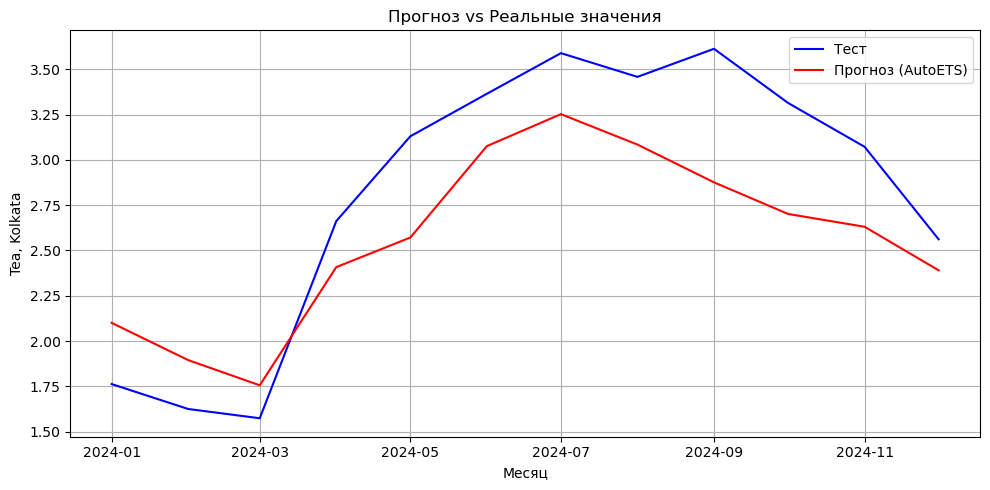

MAPE: 0.1362 (13.62%)


In [39]:
num = 15

test_start = '2024-01'
test_end = '2024-12'

series = df.iloc[:, num].dropna()
train = series[series.index < test_start]
test = series[(series.index <= test_end) & (series.index >= test_start)]

forecaster = AutoETS(auto=True, sp = 12, n_jobs=-1)  # sp=12 для месячных данных
forecaster.fit(train)
fh = ForecastingHorizon(test[(test.index >= test_start)].index, is_relative=False)
y_pred = forecaster.predict(fh)


plt.figure(figsize=(10, 5))
plt.plot(test.index.to_timestamp(), test.values, '-', color='blue', label="Тест")
plt.plot(y_pred.index.to_timestamp(), y_pred.values, '-', color='red', label="Прогноз (AutoETS)")
plt.title("Прогноз vs Реальные значения")
plt.xlabel("Месяц")
plt.ylabel(df.columns[num])
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()


mape = mean_absolute_percentage_error(test, y_pred)
print(f"MAPE: {mape:.4f} ({mape*100:.2f}%)")


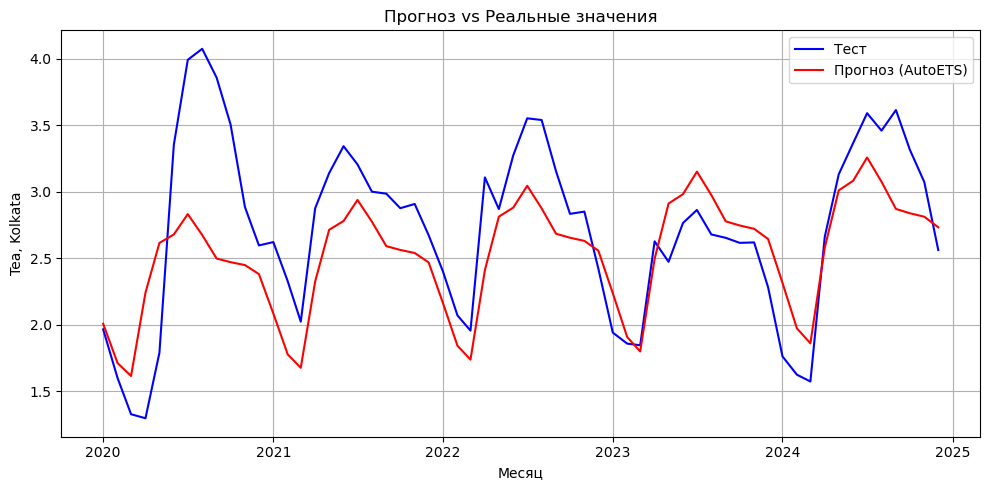

MAPE: 0.1478 (14.78%)


In [38]:
num = 15

test_start = '2020-01'
test_end = '2024-12'

series = df.iloc[:, num].dropna()
train = series[series.index < test_start]
test = series[(series.index <= test_end) & (series.index >= test_start)]

forecaster = AutoETS(auto=True, sp = 12, n_jobs=-1)  # sp=12 для месячных данных
forecaster.fit(train)
fh = ForecastingHorizon(test[(test.index >= test_start)].index, is_relative=False)
y_pred = forecaster.predict(fh)


plt.figure(figsize=(10, 5))
plt.plot(test.index.to_timestamp(), test.values, '-', color='blue', label="Тест")
plt.plot(y_pred.index.to_timestamp(), y_pred.values, '-', color='red', label="Прогноз (AutoETS)")
plt.title("Прогноз vs Реальные значения")
plt.xlabel("Месяц")
plt.ylabel(df.columns[num])
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()


mape = mean_absolute_percentage_error(test, y_pred)
print(f"MAPE: {mape:.4f} ({mape*100:.2f}%)")


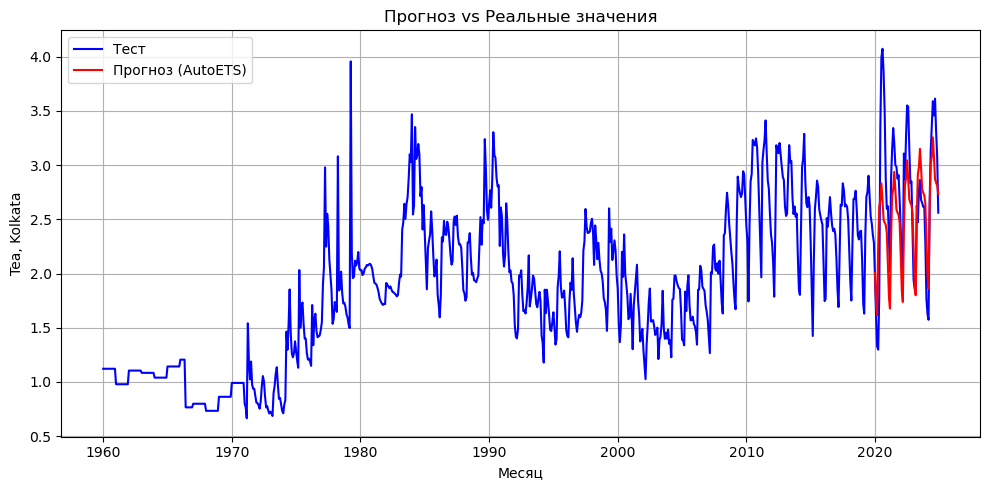

MAPE: 0.1478 (14.78%)


In [42]:
num = 15

test_start = '2020-01'
test_end = '2024-12'

series = df.iloc[:, num].dropna()
train = series[series.index < test_start]
test = series[(series.index <= test_end)]

forecaster = AutoETS(auto=True, sp = 12, n_jobs=-1)  # sp=12 для месячных данных
forecaster.fit(train)
fh = ForecastingHorizon(test[(test.index >= test_start)].index, is_relative=False)
y_pred = forecaster.predict(fh)


plt.figure(figsize=(10, 5))
plt.plot(test.index.to_timestamp(), test.values, '-', color='blue', label="Тест")
plt.plot(y_pred.index.to_timestamp(), y_pred.values, '-', color='red', label="Прогноз (AutoETS)")
plt.title("Прогноз vs Реальные значения")
plt.xlabel("Месяц")
plt.ylabel(df.columns[num])
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()


mape = mean_absolute_percentage_error(test[(test.index >= test_start)], y_pred)
print(f"MAPE: {mape:.4f} ({mape*100:.2f}%)")


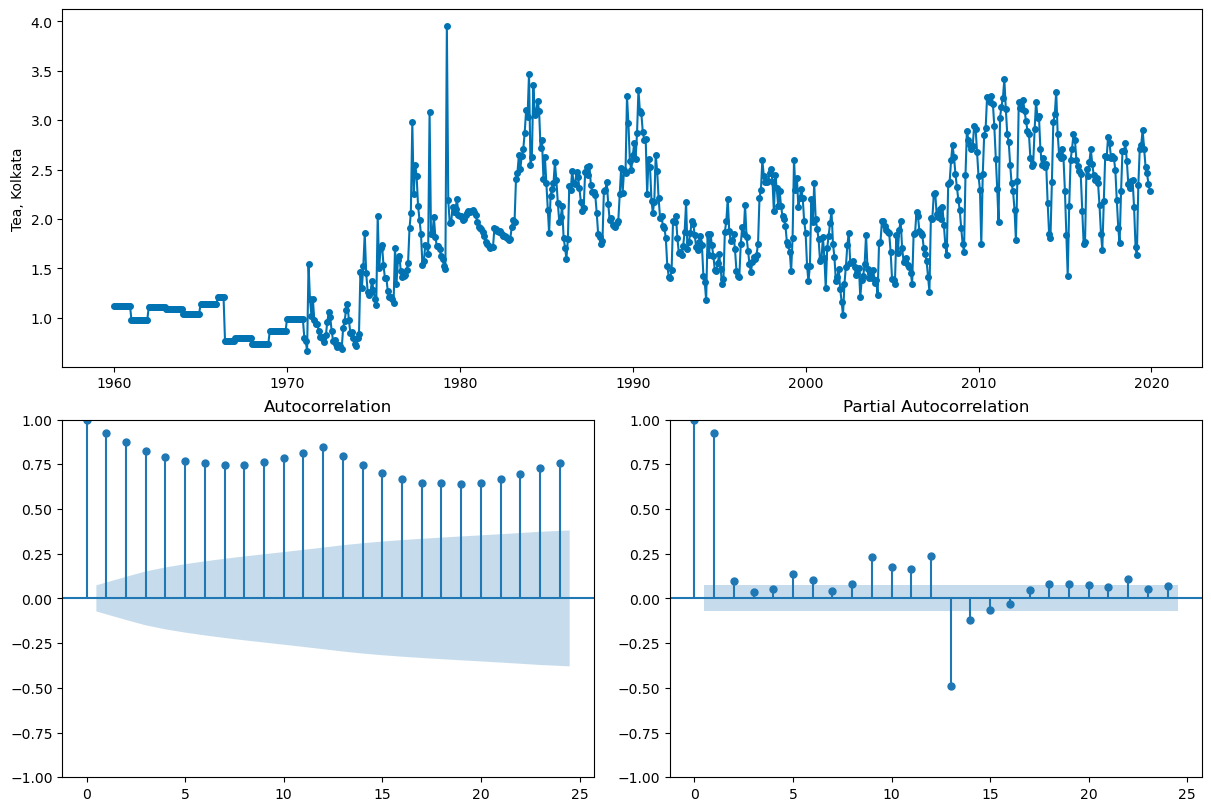

In [43]:
from sktime.utils.plotting import plot_correlations

num = 15
series = df.iloc[:, num].dropna()

test_start = '2020-01'
train = series[series.index < test_start]
fig, ax = plot_correlations(train)

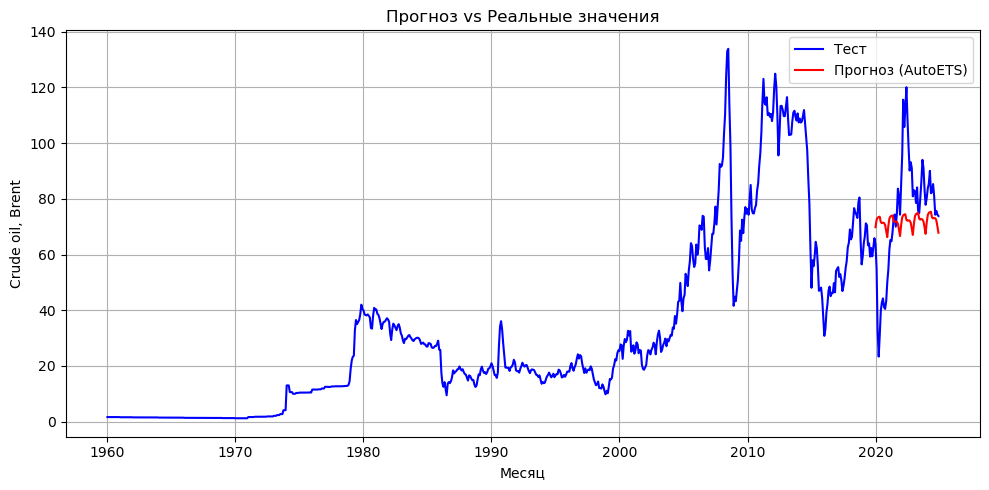

MAPE: 0.2797 (27.97%)


In [45]:
num = 1

test_start = '2020-01'
test_end = '2024-12'

series = df.iloc[:, num].dropna()
train = series[series.index < test_start]
test = series[(series.index <= test_end)]

forecaster = AutoETS(auto=True, sp = 12, n_jobs=-1)  # sp=12 для месячных данных
forecaster.fit(train)
fh = ForecastingHorizon(test[(test.index >= test_start)].index, is_relative=False)
y_pred = forecaster.predict(fh)


plt.figure(figsize=(10, 5))
plt.plot(test.index.to_timestamp(), test.values, '-', color='blue', label="Тест")
plt.plot(y_pred.index.to_timestamp(), y_pred.values, '-', color='red', label="Прогноз (AutoETS)")
plt.title("Прогноз vs Реальные значения")
plt.xlabel("Месяц")
plt.ylabel(df.columns[num])
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()


mape = mean_absolute_percentage_error(test[(test.index >= test_start)], y_pred)
print(f"MAPE: {mape:.4f} ({mape*100:.2f}%)")


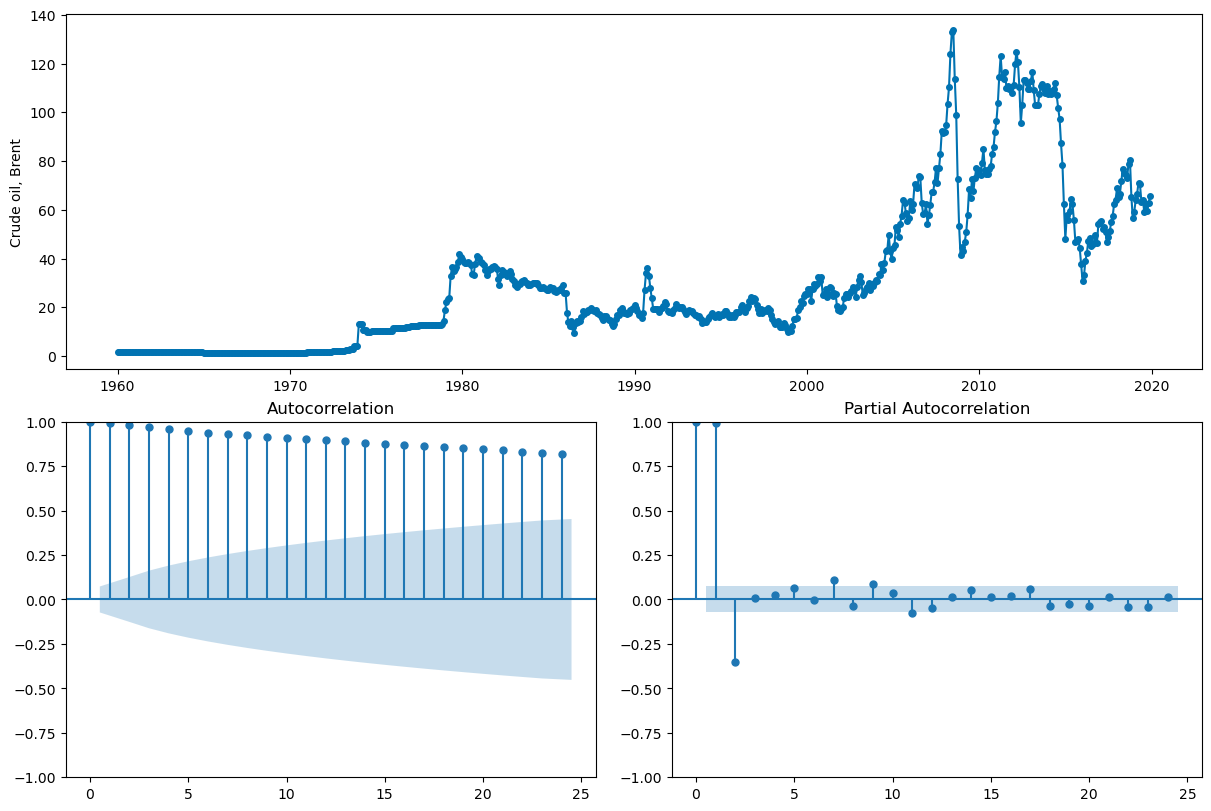

In [46]:
from sktime.utils.plotting import plot_correlations

num = 1
series = df.iloc[:, num].dropna()

test_start = '2020-01'
train = series[series.index < test_start]
fig, ax = plot_correlations(train)

(<Figure size 1600x400 with 1 Axes>, <Axes: ylabel='Crude oil, Brent'>)

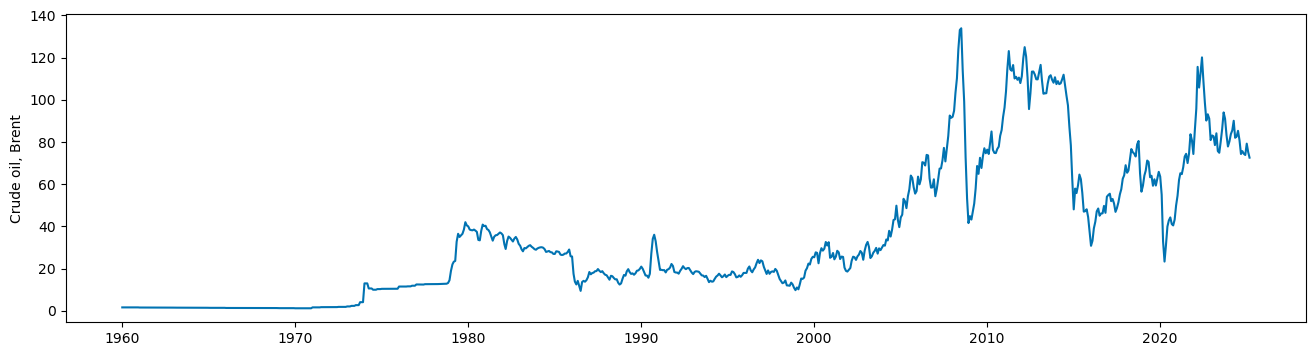

In [47]:
plot_series(series,markers=" ")